# Pathogen-recognition prediction in the Human Immune System

Kevin Meza Landeros (kmezala1)

## Introduction   
The human adaptive immune system's ability to recognize and eliminate pathogens and malignant cells is a cornerstone of health. This function is primarily mediated by T-cells, which utilize a highly specific receptor (TCR). T-cells inspect small protein fragments ( epitopes) that are "presented" to them on the surface of other cells. The incredible diversity of the TCR repertoire allows the immune system to respond to a vast number of potential threats. However, this same diversity presents a challenge: predicting which T-cell will recognize which epitope.
Solving this "specificity" problem is a central goal in computational immunology. This project confronts this challenge by developing a deep learning classifier to predict if a given (TCR, Epitope) pair will interact, leveraging the power of Convolutional Neural Networks (CNNs) to learn generalizable sequence patterns from the paired data that determine a "Yes/No" binding event.

## Background & Motivation  
A functional TCR is a heterodimer, composed of two distinct chains, an alpha (TRA) chain and a beta (TRB) chain, which pair together to form the antigen-binding site. The beta chain contains the highly diverse CDR3 loop, which is widely considered the primary determinant of specificity and is the most common chain profiled in public databases. Therefore, this project will focus exclusively on CDR3 sequences from TCR beta for all analyses.
The combinatorial space of possible CDR3 sequences is astronomical (>1015), making an exhaustive experimental mapping of all TCR-epitope pairs impossible. Experimental methods for determining TCR specificity are low-throughput, expensive, and very labor-intensive. The recent advancement of high-throughput sequencing has led to the creation of large public databases, such as VDJdb, which pair TCR sequences with their known epitope targets. This data explosion provides the necessary fuel for data-driven, machine learning approaches to tackle this problem.
The development of a computational solution can directly impact multiple areas, such as cancer, infectious diseases and autoimmunity. This would help improve diagnostics, prognostics, and foster vaccine development.


In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive/')

# Downloaded VDJ database (TSV) from path below:
# https://vdjdb.cdr3.net/search

# Read VDJdd database
df = pd.read_csv("/content/VDJdb.tsv", sep="\t", on_bad_lines='skip')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
df.head()

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
0,0,TRB,CASSPSMSTGELFF,TRBV4-2*01,TRBJ2-2*01,HomoSapiens,HLA-A*02,B2M,MHCI,YLQPRTFLL,Spike,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""identification"": ""tetramer-sort"", ""frequency...","{""study.id"": """", ""cell.subset"": """", ""subject.c...","{""cdr3"": ""CASSPSMSTGELFF"", ""cdr3_old"": ""CASSPS...",1
1,0,TRB,CSARDHVGQNTGELFF,TRBV20-1*01,TRBJ2-2*01,HomoSapiens,HLA-A*02,B2M,MHCI,YLQPRTFLL,Spike,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""identification"": ""tetramer-sort"", ""frequency...","{""study.id"": """", ""cell.subset"": """", ""subject.c...","{""cdr3"": ""CSARDHVGQNTGELFF"", ""cdr3_old"": ""CSAR...",1
2,0,TRB,CASSFGISGELFF,TRBV5-1*01,TRBJ2-2*01,HomoSapiens,HLA-A*02,B2M,MHCI,YLQPRTFLL,Spike,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""identification"": ""tetramer-sort"", ""frequency...","{""study.id"": """", ""cell.subset"": """", ""subject.c...","{""cdr3"": ""CASSFGISGELFF"", ""cdr3_old"": ""CASSFGI...",1
3,0,TRB,CATSPDPNTGELFF,TRBV24-1*01,TRBJ2-2*01,HomoSapiens,HLA-A*02,B2M,MHCI,YLQPRTFLL,Spike,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""identification"": ""tetramer-sort"", ""frequency...","{""study.id"": """", ""cell.subset"": """", ""subject.c...","{""cdr3"": ""CATSPDPNTGELFF"", ""cdr3_old"": ""CATSPD...",1
4,0,TRB,CATQDANTGELFF,TRBV15*01,TRBJ2-2*01,HomoSapiens,HLA-A*02,B2M,MHCI,YLQPRTFLL,Spike,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""identification"": ""tetramer-sort"", ""frequency...","{""study.id"": """", ""cell.subset"": """", ""subject.c...","{""cdr3"": ""CATQDANTGELFF"", ""cdr3_old"": ""CATQDAN...",0


## Pre-processing Data

Data Pre-processing
To prepare the VDJdb dataset for our classification task. The initial step was to retain only records corresponding to human (Homo sapiens) TRBs, as this represents the most common and well-annotated use case in immunoinformatics. Subsequently, the dataset was reduced to only the essential columns for this study: the CDR3 amino acid sequence, serving as the predictive feature, and the Epitope, serving as the target label. Given the fact that a given antigen can be recognized by multiple combinations of TCRs, a minimum support threshold was applied, retaining only those epitopes with at least 50 associated TCR examples. We want our model to learn generalizable patterns in such sequences, and be able to predict whether there is binding between a given TCR-Epitope pair.



In [ ]:

sns.set(style="whitegrid")

# Filter data
df_clean = df[(df['Species'] == 'HomoSapiens') & (df['Gene'] == 'TRB')].copy()
df_clean = df_clean[['CDR3', 'Epitope']]
df_clean.dropna(inplace=True)
epitope_counts = df_clean['Epitope'].value_counts()
common_epitopes = epitope_counts[epitope_counts >= 50].index
df_final = df_clean[df_clean['Epitope'].isin(common_epitopes)]

print(f"Original records: {len(df)}")
print(f"Filtered for HomoSapiens, TRB: {len(df_clean)}")
print(f"Final records for plotting (>=50 epitope): {len(df_final)}")
if not df_final.empty:
    print("\nTop 5 Epitopes in final dataset:")
    print(df_final['Epitope'].value_counts().head(5))
else:
    print("Error: No data to plot.")

Original records: 200436
Filtered for HomoSapiens, TRB: 112665
Final records for plotting (>=50 epitope): 105723

Top 5 Epitopes in final dataset:
Epitope
SLLMWITQV     29727
NLVPMVATV     18373
KLGGALQAK     13918
GILGFVFTL     10768
VISNDVCAQV     4070
Name: count, dtype: int64


Show Top 25 antigens and how many TCRs can recognize them

/tmp/ipython-input-3418789305.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


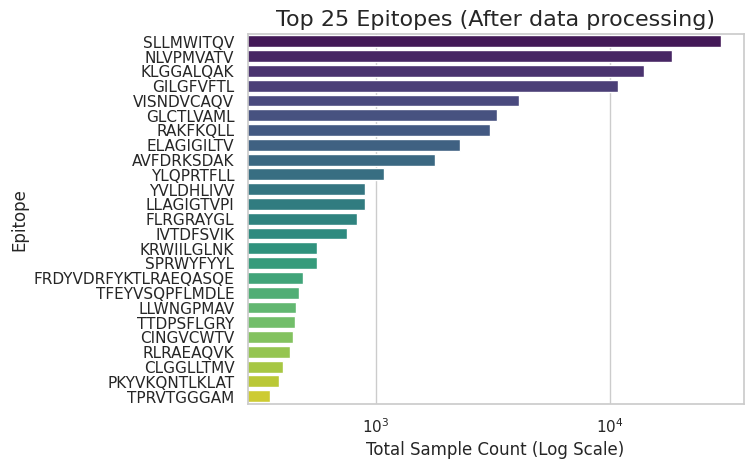

In [ ]:
TOP_N = 25
sns.countplot(
    y='Epitope',
    data=df_final,
    order=df_final['Epitope'].value_counts().index[:TOP_N],
    palette='viridis'
)
plt.title(f'Top {TOP_N} Epitopes (After data processing)', fontsize=16)
plt.xlabel('Total Sample Count (Log Scale)', fontsize=12)
plt.xscale('log')
plt.ylabel('Epitope', fontsize=12)
plt.show()

Plot the most frequent TCR aminoacids at each position. This will help us observe any features shared across them. We expect the model to learn those patterns.
The plot belows show the aa contribution for the antigen recognized by the most TCRs: **SLLMWITQV**

Generating sequence logo for the most common epitope: SLLMWITQV


<Figure size 1500x500 with 0 Axes>

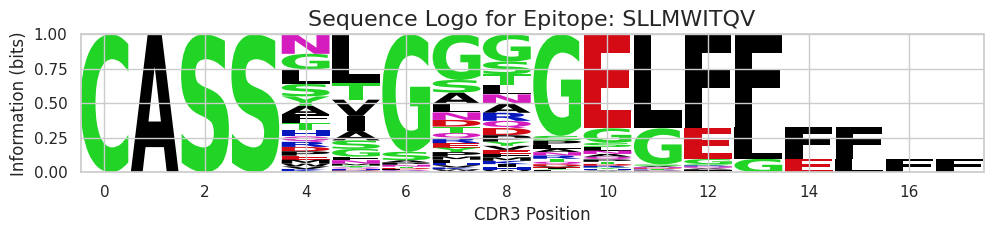

In [ ]:
# --- Sequence Logo ---

top_epitope = df_final['Epitope'].value_counts().idxmax()
print(f"Generating sequence logo for the most common epitope: {top_epitope}")
top_epitope_seqs = df_final[df_final['Epitope'] == top_epitope]['CDR3']

# --- Create a one-hot encoded matrix for these sequences ---
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i for i, aa in enumerate(AMINO_ACIDS)}

MAX_LEN = 30 # A reasonable default

encoded_seqs = []
for seq in top_epitope_seqs:
    # Ensure seq is a string, handle potential NaN values
    if not isinstance(seq, str):
        continue
    encoded = np.zeros((MAX_LEN, len(AMINO_ACIDS)))
    for i, aa in enumerate(seq[:MAX_LEN]):
        if aa in aa_to_int:
            encoded[i, aa_to_int[aa]] = 1
    encoded_seqs.append(encoded)

if encoded_seqs:
    # Stack into a 3D array
    X_logo = np.stack(encoded_seqs)

    # --- Convert to a frequency matrix & format for logomaker ---
    counts_matrix = X_logo.sum(axis=0)
    # Avoid division by zero if all sequences were empty/invalid
    if X_logo.shape[0] > 0:
        freq_matrix = counts_matrix / X_logo.shape[0]
        logo_df = pd.DataFrame(freq_matrix, columns=list(AMINO_ACIDS))
        logo_df = logo_df.loc[(logo_df != 0).any(axis=1)]

        # --- Generate logo ---
        if not logo_df.empty:
            plt.figure(figsize=(15, 5))
            logo = logomaker.Logo(logo_df)
            logo.style_glyphs()
            logo.ax.set_title(f'Sequence Logo for Epitope: {top_epitope}', fontsize=16)
            logo.ax.set_xlabel('CDR3 Position', fontsize=12)
            logo.ax.set_ylabel('Information (bits)', fontsize=12)
            plt.tight_layout()
            plt.show()


Viasualize TCRs per Epitope before and after data pre-processing

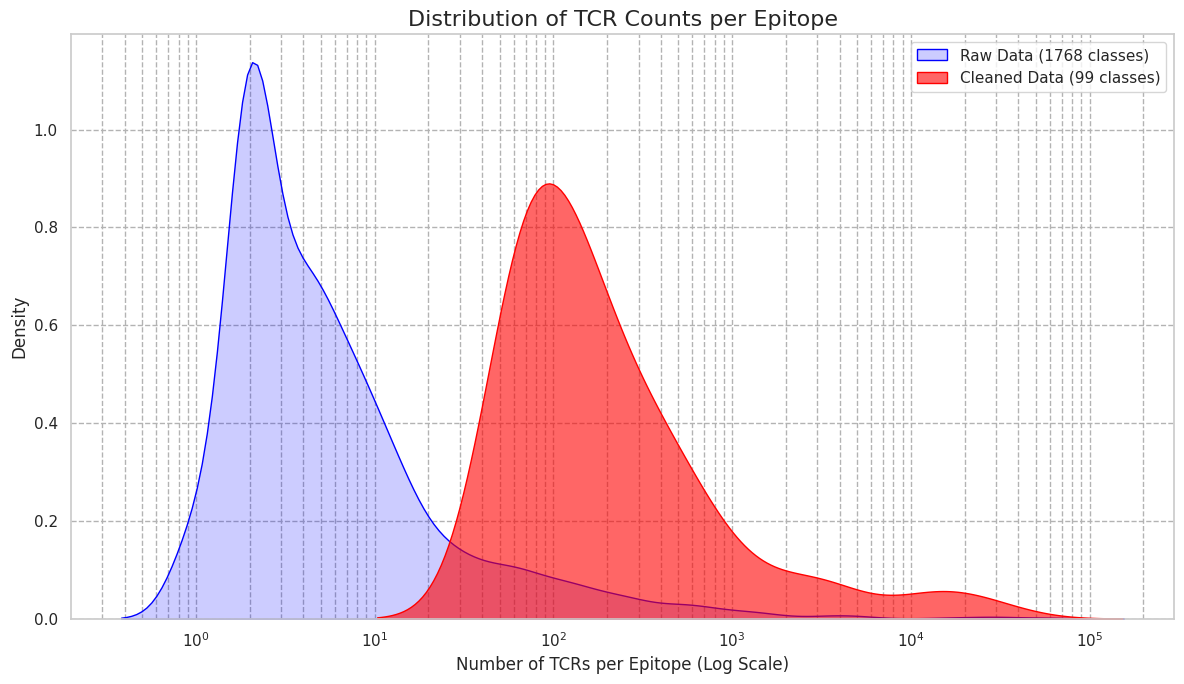

In [ ]:

# Get the Series of counts for each dataset
raw_epitope_counts = df['Epitope'].value_counts()
final_epitope_counts = df_final['Epitope'].value_counts()

if raw_epitope_counts.empty or final_epitope_counts.empty:
    print("Skipping plot: No epitope counts found in one or both dataframes.")
else:
    plt.figure(figsize=(12, 7))

    # Plot the density of the counts for the pre-filtered data
    sns.kdeplot(
        raw_epitope_counts,
        label=f'Raw Data ({len(raw_epitope_counts)} classes)',
        color='blue',
        log_scale=True,  # Use log scale for x-axis
        fill=True,
        alpha=0.2,
        warn_singular=False
    )

    # Plot the density of the counts for the filtered data
    sns.kdeplot(
        final_epitope_counts,
        label=f'Cleaned Data ({len(final_epitope_counts)} classes)',
        color='red',
        log_scale=True,
        fill=True,
        alpha=0.6,
        warn_singular=False
    )

    plt.title('Distribution of TCR Counts per Epitope', fontsize=16)
    plt.xlabel('Number of TCRs per Epitope (Log Scale)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.show()


## Generate Negatively-labeled data

To train a robust binary classifier, it is essential to provide the model with examples of both positive (binding) and negative (non-binding) interactions. While the VDJdb database provides a rich source of positively labeled TCR-epitope pairs, a comparable database of experimentally verified non-binding pairs does not, to our knowledge, exist. To overcome this limitation, we generated a synthetic negative dataset. This was achieved by randomly shuffling and pairing TCR and epitope sequences from our positive set, under the assumption that a randomly generated pair is highly unlikely to have a binding affinity. Any randomly generated pair that already existed in the positive dataset was excluded. To prevent the model from developing a bias towards one class, we generated a negative dataset equal in size to the positive set. The final dataset therefore consists of 211,446 total examples: 105,723 positively- and 105,723 negatively-labeled binding pairs.



In [ ]:
import pandas as pd
import numpy as np

positive_df = df_final.copy()
positive_df['label'] = 1

# --- Create Negative Pairs ---
all_tcrs = positive_df['CDR3'].unique()
all_epitopes = positive_df['Epitope'].unique()

# Existing positive pairs
existing_pairs = set(zip(positive_df['CDR3'], positive_df['Epitope']))

negative_pairs = []
num_neg_samples = len(positive_df)

while len(negative_pairs) < num_neg_samples:
    # Randomly pick a TCR and an epitope
    rand_tcr = np.random.choice(all_tcrs)
    rand_epitope = np.random.choice(all_epitopes)

    # If the pair doesn't already exist as a positive example, add it
    if (rand_tcr, rand_epitope) not in existing_pairs:
        negative_pairs.append({'CDR3': rand_tcr, 'Epitope': rand_epitope, 'label': 0})

negative_df = pd.DataFrame(negative_pairs)

# Combine positive and negative pairs into  final dataset
final_paired_df = pd.concat([positive_df, negative_df]).sample(frac=1).reset_index(drop=True)

print(f"Total samples: {len(final_paired_df)}")
print("Class distribution:")
print(final_paired_df['label'].value_counts())

Total samples: 211446
Class distribution:
label
0    105723
1    105723
Name: count, dtype: int64


As a control step, there let's check the logo of the same peptide as before (SLLMWITQV). We would expect no common amioacids in the paired TCR sequences, other than the first conserved 4 aminoacids "CASS".

Generating sequence logo for the most common epitope: SLLMWITQV


<Figure size 1500x500 with 0 Axes>

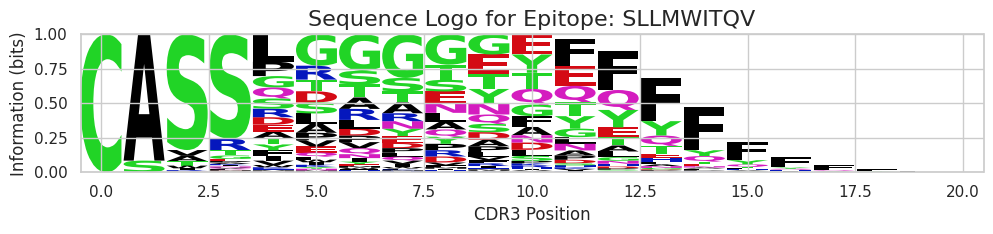

In [ ]:
# --- Sequence Logo ---

top_epitope = "SLLMWITQV"
print(f"Generating sequence logo for the most common epitope: {top_epitope}")
top_epitope_seqs = negative_df[negative_df['Epitope'] == top_epitope]['CDR3']

# --- Create a one-hot encoded matrix for these sequences ---
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i for i, aa in enumerate(AMINO_ACIDS)}

MAX_LEN = 30 # A reasonable default

encoded_seqs = []
for seq in top_epitope_seqs:
    # Ensure seq is a string, handle potential NaN values
    if not isinstance(seq, str):
        continue
    encoded = np.zeros((MAX_LEN, len(AMINO_ACIDS)))
    for i, aa in enumerate(seq[:MAX_LEN]):
        if aa in aa_to_int:
            encoded[i, aa_to_int[aa]] = 1
    encoded_seqs.append(encoded)

if encoded_seqs:
    # Stack into a 3D array
    X_logo = np.stack(encoded_seqs)

    # --- Convert to a frequency matrix & format for logomaker ---
    counts_matrix = X_logo.sum(axis=0)
    # Avoid division by zero if all sequences were empty/invalid
    if X_logo.shape[0] > 0:
        freq_matrix = counts_matrix / X_logo.shape[0]
        logo_df = pd.DataFrame(freq_matrix, columns=list(AMINO_ACIDS))
        logo_df = logo_df.loc[(logo_df != 0).any(axis=1)]

        # --- Generate logo ---
        if not logo_df.empty:
            plt.figure(figsize=(15, 5))
            logo = logomaker.Logo(logo_df)
            logo.style_glyphs()
            logo.ax.set_title(f'Sequence Logo for Epitope: {top_epitope}', fontsize=16)
            logo.ax.set_xlabel('CDR3 Position', fontsize=12)
            logo.ax.set_ylabel('Information (bits)', fontsize=12)
            plt.tight_layout()
            plt.show()


As predicted, there is not a clear pattern as before, and it appears rather random. Which gives us some confidence.

## Build the CNN Classifier

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
#  FEATURE ENCODING (TCR + Epitope)
# ==============================================================================

AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i for i, aa in enumerate(AMINO_ACIDS)}
NUM_AMINO_ACIDS = len(AMINO_ACIDS)

# Determine padding lengths
MAX_TCR_LEN = int(final_paired_df['CDR3'].str.len().quantile(0.95))
MAX_EPI_LEN = int(final_paired_df['Epitope'].str.len().quantile(0.95))
# MAX_TCR_LEN = final_paired_df['CDR3'].str.len().max()
# MAX_EPI_LEN = final_paired_df['Epitope'].str.len().max()
TOTAL_LEN = MAX_TCR_LEN + MAX_EPI_LEN

print(f"Max TCR length (padded): {MAX_TCR_LEN}")
print(f"Max Epitope length (padded): {MAX_EPI_LEN}")
print(f"Total input length: {TOTAL_LEN}")

def encode_pair(tcr_seq, epi_seq):
    # Initialize empty tensor for the pair
    encoded = np.zeros((TOTAL_LEN, NUM_AMINO_ACIDS))

    # Encode TCR
    for i, aa in enumerate(tcr_seq[:MAX_TCR_LEN]):
        if aa in aa_to_int:
            encoded[i, aa_to_int[aa]] = 1

    # Encode Epitope
    for i, aa in enumerate(epi_seq[:MAX_EPI_LEN]):
        if aa in aa_to_int:
            encoded[MAX_TCR_LEN + i, aa_to_int[aa]] = 1

    return encoded

# Encoding all pairs
X_paired = np.array(
    [encode_pair(tcr, epi) for tcr, epi in zip(final_paired_df['CDR3'], final_paired_df['Epitope'])]
)
y_paired = final_paired_df['label'].values

print("Encoding complete. Shape of X:", X_paired.shape)
print("Shape of y:", y_paired.shape)

# ==============================================================================
# MODEL SETUP
# ==============================================================================

# Split data: 80 train, 20 test
X_train, X_test, y_train, y_test = train_test_split(
    X_paired, y_paired, test_size=0.2, random_state=42, stratify=y_paired
)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ==============================================================================
# MODEL ARCHITECTURE
# ==============================================================================

class TCRBinder(nn.Module):
    def __init__(self, num_amino_acids=NUM_AMINO_ACIDS, max_len=TOTAL_LEN):
        super(TCRBinder, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=num_amino_acids, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Calculate flattened size dynamically
        flattened_size = 64 * (max_len // 4) # Each pooling layer with kernel_size=2 divides length by 2

        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten all dimensions except batch
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Instantiate the model
model = TCRBinder()
print("\nModel Architecture:")
print(model)


Max TCR length (padded): 18
Max Epitope length (padded): 14
Total input length: 32
Encoding complete. Shape of X: (211446, 32, 20)
Shape of y: (211446,)

Model Architecture:
TCRBinder(
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


## Training

Our final, balanced dataset, containing over 211,446 positive (binding) and synthetic negative (non-binding) pairs, was split into training and test sets. This split was stratified to ensure the 1:1 ratio of positive to negative samples was preserved in both the training and the testing. We developed a model called TCRBinder. The model was then trained in a supervised manner. During this process, the network was iteratively presented with pairs and penalized for incorrect "binding" or "non-binding" predictions. Through this optimization, the model's internal filters were progressively tuned to recognize the critical sequence motifs and biophysical patterns within the TCR-epitope pair that define a successful binding event. The final, trained model represents a "learned" predictive function for TCR specificity, which was then validated on the held-out test data.

In [ ]:
# ==============================================================================
# TRAINING
# ==============================================================================

# Loss Function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 20

print(f"\nStarting training for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for i, (pairs, labels) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(pairs)

        # Get Loss
        loss = criterion(outputs, labels.unsqueeze(1))

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

print("Finished Training")




Starting training for 20 epochs...
Epoch [1/20], Loss: 0.2876
Epoch [2/20], Loss: 0.2524
Epoch [3/20], Loss: 0.2433
Epoch [4/20], Loss: 0.2360
Epoch [5/20], Loss: 0.2308
Epoch [6/20], Loss: 0.2259
Epoch [7/20], Loss: 0.2220
Epoch [8/20], Loss: 0.2174
Epoch [9/20], Loss: 0.2142
Epoch [10/20], Loss: 0.2112
Epoch [11/20], Loss: 0.2081
Epoch [12/20], Loss: 0.2045
Epoch [13/20], Loss: 0.2026
Epoch [14/20], Loss: 0.2000
Epoch [15/20], Loss: 0.1971
Epoch [16/20], Loss: 0.1952
Epoch [17/20], Loss: 0.1922
Epoch [18/20], Loss: 0.1905
Epoch [19/20], Loss: 0.1881
Epoch [20/20], Loss: 0.1873
Finished Training


## Model Evaluation

The model demonstrated a strong ability to distinguish between binding and non-binding pairs, achieving a metric of 0.97 for the AUROC curve, which confirms the model has learned a robust, generalizable signal for classification. The model's performance is detailed in the Confusion Matrix. The ROC Curve, shows a curve that bows toward the top-left corner, exceeding the "random-classifier" baseline.
This performance is further contextualized by the Precision-Recall (PR) Curve. The model achieved an Average Precision (AP) score of 0.97, which also suggests the model's predictions are reliable.
To understand how the model made its decisions, we analyzed the distribution of its predicted probabilities. This plot shows two very distinct, minimally overlapping distributions for the true positive and true negative classes. The "No Binding" (Label 0) samples are correctly piled up with predicted probabilities near 0.0, while the "Binding" (Label 1) samples are correctly piled up near 1.0. The region of overlap (probabilities between 0.3 and 0.7) represents the model's "region of confusion" and visually explains the source of the false positives and false negatives reported in the confusion matrix.



Evaluating model on test set...

Test AUROC Score: 0.9692

Classification Report:
                precision    recall  f1-score   support

No Binding (0)       0.90      0.93      0.92     21145
   Binding (1)       0.93      0.89      0.91     21145

      accuracy                           0.91     42290
     macro avg       0.91      0.91      0.91     42290
  weighted avg       0.91      0.91      0.91     42290


Confusion Matrix:


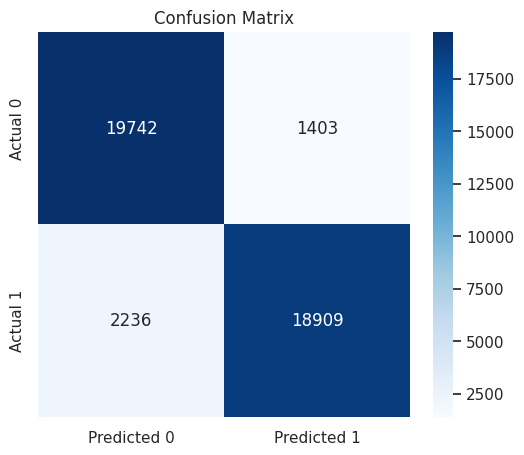

In [ ]:
# ==============================================================================
# EVALUATION
# ==============================================================================

model.eval()
all_labels = []
all_probs = []
all_preds = []

print("\nEvaluating model on test set...")
with torch.no_grad():
    for pairs, labels in test_loader:
        outputs = model(pairs)

        # --- Get predictions
        probs = torch.sigmoid(outputs).squeeze(1) # probabilities
        preds = (probs >= 0.5).long() # Get 0/1 predictions by rounding at 0.5

        all_labels.extend(labels.numpy())
        all_probs.extend(probs.numpy())
        all_preds.extend(preds.numpy())

# --- Metrics ---
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

# AUROC
auc_score = roc_auc_score(all_labels, all_probs)
print(f"\nTest AUROC Score: {auc_score:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['No Binding (0)', 'Binding (1)']))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()

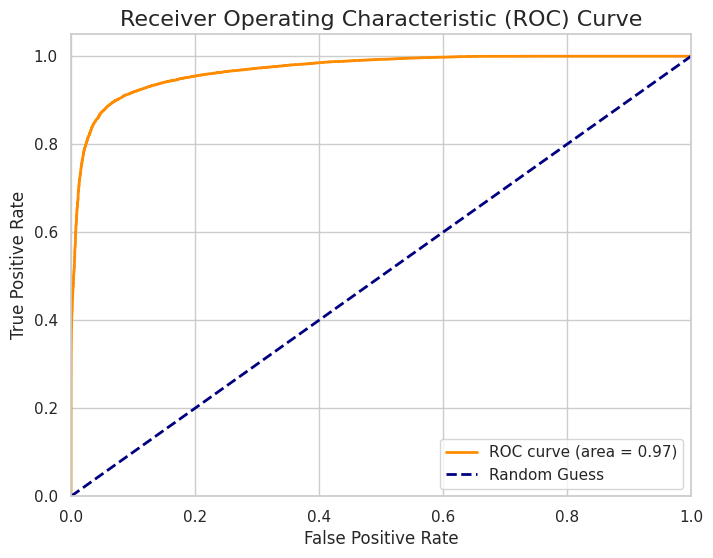

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

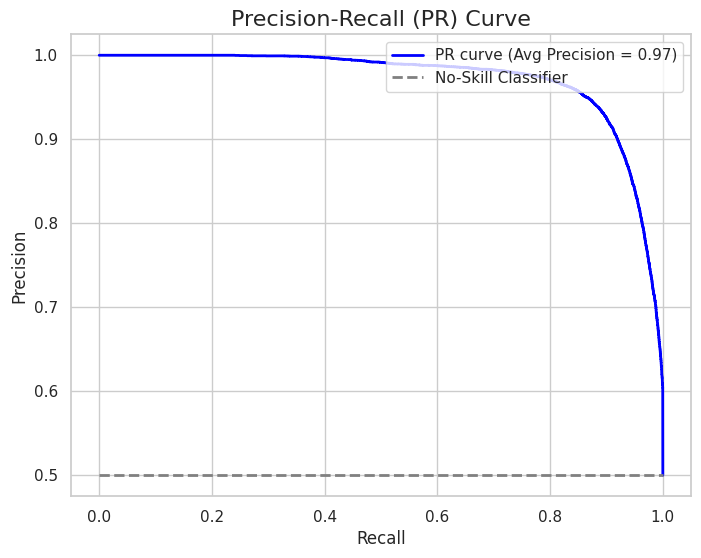

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- ROC Curve

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
avg_precision = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'PR curve (Avg Precision = {avg_precision:.2f})')
no_skill = len(all_labels[all_labels==1]) / len(all_labels)
plt.plot([0, 1], [no_skill, no_skill], color='gray', lw=2,
         linestyle='--', label='No-Skill Classifier')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall (PR) Curve', fontsize=16)
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Predicted Probability Distribution

Two histograms overlaid: one shows the distribution of predicted probabilities for the actual negative samples, and the other shows the distribution for the actual positive samples.


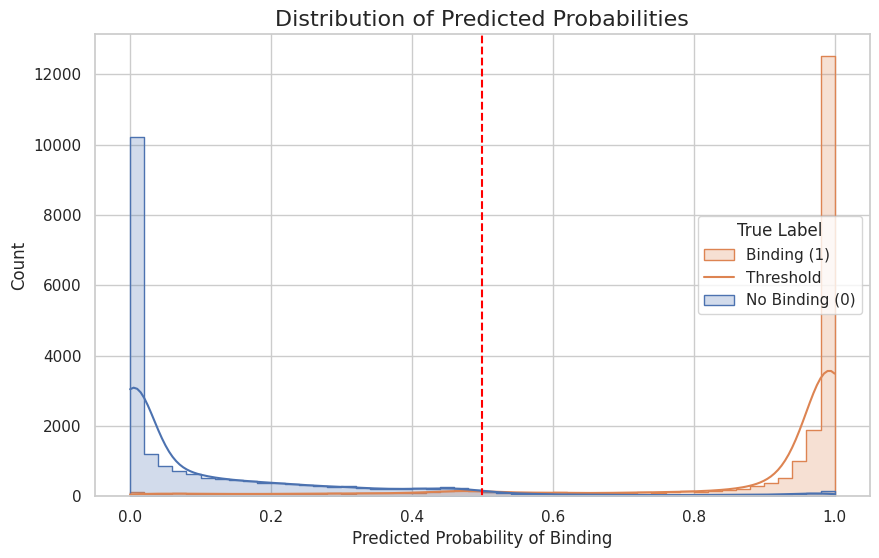

In [ ]:
import seaborn as sns
import pandas as pd

prob_df = pd.DataFrame({
    'Probability': all_probs,
    'True Label': all_labels
})

plt.figure(figsize=(10, 6))
sns.histplot(data=prob_df, x='Probability', hue='True Label',
             bins=50, kde=True, element='step')
plt.title('Distribution of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability of Binding', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend(title='True Label', labels=['Binding (1)', 'Threshold', 'No Binding (0)'])
plt.grid(True)
plt.show()

## Binding Motifs

Beyond classification metrics, the trained model was used as a scientific tool to extract biological insights. We performed an in silico mutagenesis on a high-confidence TCR-epitope pair to identify which residues the model considered critical for binding.

The resulting heatmap visualizes the model's sensitivity to every possible single-point mutation within the TCR's CDR3 sequence. We identified several "hotspot" positions (e.g., 4,12) where nearly any mutation from the original amino acid (highlighted in green) caused the model's predicted binding probability to drop significantly (seen as dark blue vertical bands). Conversely, other positions were highly "tolerant" to mutation (seen as red or white columns). Highlighting that mutations in specific locations caused an overall better binding prediction score (columns 6,7)
This result confirms that the model learned specific, biologically plausible sequence rules. It did not simply memorize the data, but learned to associate specific amino acids at specific positions with a successful binding event.


TCR:      CASSPSMSTGELFF
Epitope:  YLQPRTFLL (held constant)
Original Binding Probability: 0.4897
Mutagenesis complete.


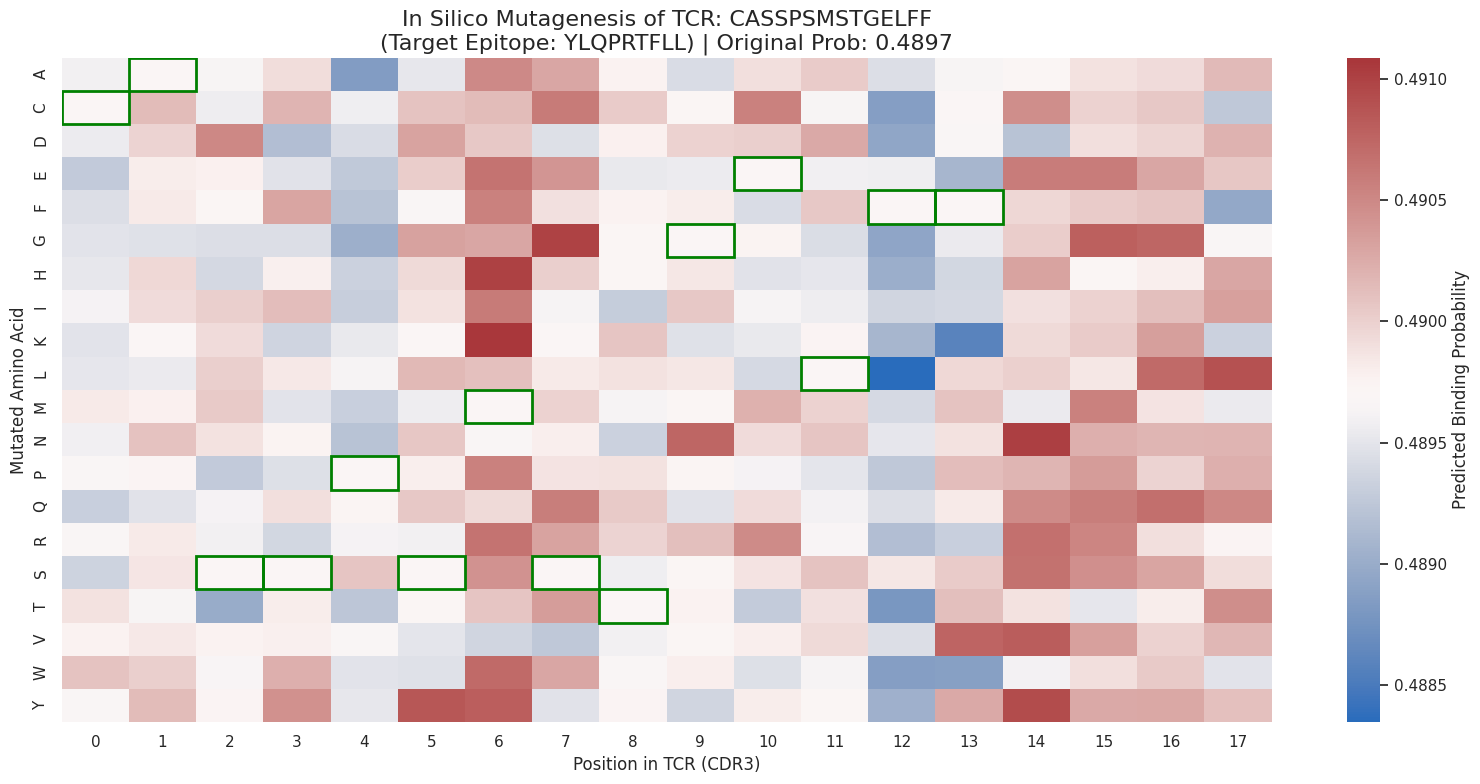

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt


# --- Select a Strong Positive Pair ---
sample_pair = positive_df.iloc[0]
original_tcr = sample_pair['CDR3']
original_epi = sample_pair['Epitope']

print(f"TCR:      {original_tcr}")
print(f"Epitope:  {original_epi} (held constant)")

# --- Original Prediction ---
original_encoded = encode_pair(original_tcr, original_epi)
original_tensor = torch.tensor(original_encoded, dtype=torch.float32).permute(1, 0).unsqueeze(0)

model.eval()
with torch.no_grad():
    original_logit = model(original_tensor)
    original_prob = torch.sigmoid(original_logit).item()

print(f"Original Binding Probability: {original_prob:.4f}")

# --- Perform In Silico Mutations (TCR-Only) ---
tcr_mutagenesis_heatmap = np.zeros((MAX_TCR_LEN, NUM_AMINO_ACIDS))

for pos in range(MAX_TCR_LEN):
    for aa_idx in range(NUM_AMINO_ACIDS):
        mutant_tensor = original_tensor.clone()
        mutant_tensor[0, :, pos] = 0.0
        mutant_tensor[0, aa_idx, pos] = 1.0

        # Get the model's prediction
        with torch.no_grad():
            mutant_logit = model(mutant_tensor)
            mutant_prob = torch.sigmoid(mutant_logit).item()

        tcr_mutagenesis_heatmap[pos, aa_idx] = mutant_prob

print("Mutagenesis complete.")

# --- Heatmap ---

heatmap_to_plot = tcr_mutagenesis_heatmap.T

plt.figure(figsize=(16, 8)) # Adjusted figure size
ax = sns.heatmap(
    heatmap_to_plot,
    cmap='vlag',
    center=original_prob,
    xticklabels=1,
    yticklabels=list(AMINO_ACIDS),
    cbar_kws={'label': 'Predicted Binding Probability'}
)

# Highlight the original TCR sequence
for i, aa_char in enumerate(original_tcr[:MAX_TCR_LEN]):
    if aa_char in aa_to_int:
        aa_idx = aa_to_int[aa_char]
        ax.add_patch(plt.Rectangle((i, aa_idx), 1, 1,
                                   fill=False, edgecolor='green', lw=2))

ax.set_title(f'In Silico Mutagenesis of TCR: {original_tcr}\n(Target Epitope: {original_epi}) | Original Prob: {original_prob:.4f}',
             fontsize=16)
ax.set_xlabel('Position in TCR (CDR3)', fontsize=12)
ax.set_ylabel('Mutated Amino Acid', fontsize=12)

plt.tight_layout()
plt.show()

Now you can find the best a for each position

In [37]:
# Find the index of the highest-scoring AA at each position
best_aa_indices = np.argmax(tcr_mutagenesis_heatmap, axis=1)
best_aa_scores = np.max(tcr_mutagenesis_heatmap, axis=1)

# Build the optimal sequence
optimal_tcr_sequence_list = []
for pos in range(MAX_TCR_LEN):
    best_index = best_aa_indices[pos]
    best_aa = AMINO_ACIDS[best_index]
    best_score = best_aa_scores[pos]

    print(f"Position {pos:02d}: Best AA is '{best_aa}' (Binding Prob: {best_score:.4f})")
    optimal_tcr_sequence_list.append(best_aa)

# Optimal sequence string
optimal_tcr_sequence = "".join(optimal_tcr_sequence_list)

print("\n-------------------------------------------------")
print(f"Computationally Optimized TCR Sequence:\n{optimal_tcr_sequence}")
print("-------------------------------------------------")

Position 00: Best AA is 'W' (Binding Prob: 0.4901)
Position 01: Best AA is 'Y' (Binding Prob: 0.4901)
Position 02: Best AA is 'D' (Binding Prob: 0.4905)
Position 03: Best AA is 'Y' (Binding Prob: 0.4904)
Position 04: Best AA is 'S' (Binding Prob: 0.4901)
Position 05: Best AA is 'Y' (Binding Prob: 0.4909)
Position 06: Best AA is 'K' (Binding Prob: 0.4911)
Position 07: Best AA is 'G' (Binding Prob: 0.4910)
Position 08: Best AA is 'K' (Binding Prob: 0.4901)
Position 09: Best AA is 'N' (Binding Prob: 0.4908)
Position 10: Best AA is 'C' (Binding Prob: 0.4906)
Position 11: Best AA is 'D' (Binding Prob: 0.4903)
Position 12: Best AA is 'S' (Binding Prob: 0.4899)
Position 13: Best AA is 'V' (Binding Prob: 0.4908)
Position 14: Best AA is 'N' (Binding Prob: 0.4910)
Position 15: Best AA is 'G' (Binding Prob: 0.4908)
Position 16: Best AA is 'G' (Binding Prob: 0.4907)
Position 17: Best AA is 'L' (Binding Prob: 0.4909)

-------------------------------------------------
Computationally Optimized TCR S

## Study Limitations

While this project establishes a strong baseline, it is crucial to acknowledge its limitations, which also serve as clear directions for future work.

The model's performance is fundamentally constrained by the available public data. VDJdb, while extensive, is limited to the CDR3 of the TCR beta-chain, neglecting the contributions of the alpha-chain and other CDR loops (CDR1, CDR2), which also influence binding. Furthermore, there is a lack of experimentally-verified negative (non-binding) pairs. Our approach has known limitations, such as the possibility of generating a pair with undiscovered cross-reactivity, and thus should be considered a plausible but not experimentally-verified negative set.

The choice of a simple CNN, while effective, does not capture long-range dependencies within the sequence as explicitly as architectures like Recurrent Neural Networks (RNNs) or Transformers might. Additionally, the use of one-hot encoding treats each amino acid as an independent entity, ignoring the underlying biochemical similarities between them. More sophisticated embeddings could provide richer input to the model.

The most significant limitation is that our model is HLA-agnostic. In reality, TCR binding is HLA-restricted, meaning a TCR recognizes an epitope only when presented by a specific HLA molecule. By ignoring the HLA context, our model learns a generalized representation of binding that may not hold true for all genetic backgrounds. Incorporating HLA information is a critical next step for developing a clinically relevant tool.



## Discussion
This project successfully demonstrated the development and validation of a CNN for the generalizable, pair-wise prediction of TCR-epitope binding. One of the model's strengths is the flexible binary classification that is not constrained to a fixed set of known antigens.

The model achieved a strong predictive performance on a held-out test set, with an Area Under the ROC Curve (AUROC) of 0.97. This indicates a high degree of separability between the positive (VDJdb-derived) and synthetic negative (shuffled) data pairs.

The model's true utility was demonstrated in its interpretability. By employing in silico mutagenesis, we were able to probe the trained model to identify residue-level "hotspots" critical for binding. However, the limitations of this proof-of-concept are significant and define clear paths for future work.

In conclusion, this project serves as a robust framework for in silico TCR specificity prediction. The combination of a CNN architecture with the mutation exercise that provides a powerful tool for discovering the sequence-level rules of immune recognition. Future iterations incorporating multi-chain and MHC-specific data, built upon this foundation, hold the potential to accelerate personalized immunotherapy and vaccine development.